In [1]:
%matplotlib inline
from sklearn.cross_decomposition import CCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


class LAM_Linear(nn.Module):
    def __init__(self, d_o, d_z, d_a):
        super(LAM_Linear, self).__init__()
        # self.A = nn.Linear(d_o, d_o, bias=False)
        # self.B = nn.Linear(d_z, d_o, bias=False)
        self.C = nn.Linear(d_o, d_z, bias=False)
        self.D = nn.Linear(d_o, d_z, bias=False)
        self.E = nn.Linear(d_z, d_o, bias=False)
        self.action_pred = nn.Linear(d_z, d_a)

    def forward(self, o, o_next):
        z = self.C(o) + self.D(o_next)
        obs_pred = o + self.E(z)
        action = self.action_pred(z)
        return obs_pred, action, z

In [2]:
def principal_angles(X, Y):
    # Orthonormalize the basis vectors using QR decomposition
    Q1, _ = np.linalg.qr(X)
    Q2, _ = np.linalg.qr(Y)
    
    # Compute the product of transposed Q1 and Q2
    M = Q1.T @ Q2
    
    # Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(M)

    # Clip singular values to avoid numerical errors (arccos domain [-1, 1])
    S_clipped = np.clip(S, -1.0, 1.0)

    # Compute principal angles in radians (sorted in ascending order)
    angles_rad = np.arccos(S_clipped)
    
    return angles_rad

def tensorboard_smooth(data, alpha=0.6):
    """Apply exponential moving average smoothing to 1D data.
    
    Args:
        data: Input array (np.ndarray or pd.Series)
        alpha: Smoothing factor (0 < alpha ≤ 1), default 0.6 (TensorBoard's default)
    
    Returns:
        Smoothed array with same dtype as input
    """
    # Convert Series to numpy array while preserving index
    if isinstance(data, pd.Series):
        original_index = data.index
        data = data.values
    else:
        original_index = None

    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    
    for i in range(1, len(data)):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i-1]

    # Reconstruct original data type
    return pd.Series(smoothed, index=original_index) if original_index is not None else smoothed

def calculate_cca(X, Y):

    cca = CCA(n_components=1)
    cca.fit(X, Y) 

    x_c, y_c = cca.transform(X, Y)
    corr = np.corrcoef(x_c.T, y_c.T)[0, 1]

    return corr



In [ ]:
N = 128
num_actions = 5
num_others = 5
dim = 128
dim_z = 5
discrete_actions = False

action_embeddings = np.random.randn(dim, num_actions)
# action_embeddings[:num_actions] = 0
action_embeddings, _ = np.linalg.qr(action_embeddings) 
# action_embeddings = action_embeddings * 1.6
# action_embeddings = action_embeddings / np.linalg.norm(action_embeddings, axis=0, keepdims=True)

others_embeddings = np.random.randn(dim, num_others)
# others_embeddings[num_actions:] = 0
others_embeddings, _ = np.linalg.qr(others_embeddings) 
# others_embeddings = others_embeddings * 1.6

main_lam = LAM_Linear(dim, dim_z, num_actions)

record = []

epsilon_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 6.0]

for epsilon in epsilon_list:

    lam = LAM_Linear(dim, dim_z, num_actions)
    lam.load_state_dict(main_lam.state_dict())
    opt = optim.Adam(lam.parameters())

    for i_batch in range(5000):

        if discrete_actions:
            actions = np.random.randint(num_actions, size=(N,))
            A = np.zeros((num_actions, N))
            A[actions, np.arange(N)] = 1
        else:
            A = np.random.rand(num_actions, N)
        act_targ = torch.tensor(A.T, dtype=torch.float32)

        noise = np.random.randn(dim, N) / np.sqrt(dim) * epsilon

        Q = action_embeddings @ A 
        O = np.random.rand(dim, N)
        Op = O + Q + noise

        tensor_O = torch.tensor(O.T, dtype=torch.float32)
        tensor_Op = torch.tensor(Op.T, dtype=torch.float32)

        obs_pred, act_pred, z = lam(tensor_O, tensor_Op)
        loss_obs = nn.MSELoss()(obs_pred, tensor_Op)

        X = z.detach().numpy()
        Y = act_targ.detach().numpy()
        cca = calculate_cca(X, Y)

        mask = (torch.rand(N) <= 1.0)
        # loss_act = (((z - act_targ) ** 2).mean(1) * mask).mean()
        loss_act = (((act_pred - act_targ) ** 2).mean(1) * mask).mean()

        # loss = loss_obs + loss_act
        loss = loss_obs

        opt.zero_grad()
        loss.backward()
        opt.step()

        angles = principal_angles(action_embeddings, lam.E.weight.detach().numpy())
        max_angle = np.max(angles)
        bngles = principal_angles(others_embeddings, lam.E.weight.detach().numpy())
        max_bngle = np.max(bngles)

        record.append({
            'noise': epsilon,
            'batch': i_batch,
            'loss_act': loss_act.item(),
            'loss_obs': loss_obs.item(),
            'loss': loss.item(),
            'angle': max_angle,
            'bngle': max_bngle,
            'cca': cca,
        })

record = pd.DataFrame(record)

/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/pyt

# W/o action label

Text(0.5, 1.0, 'CCA')

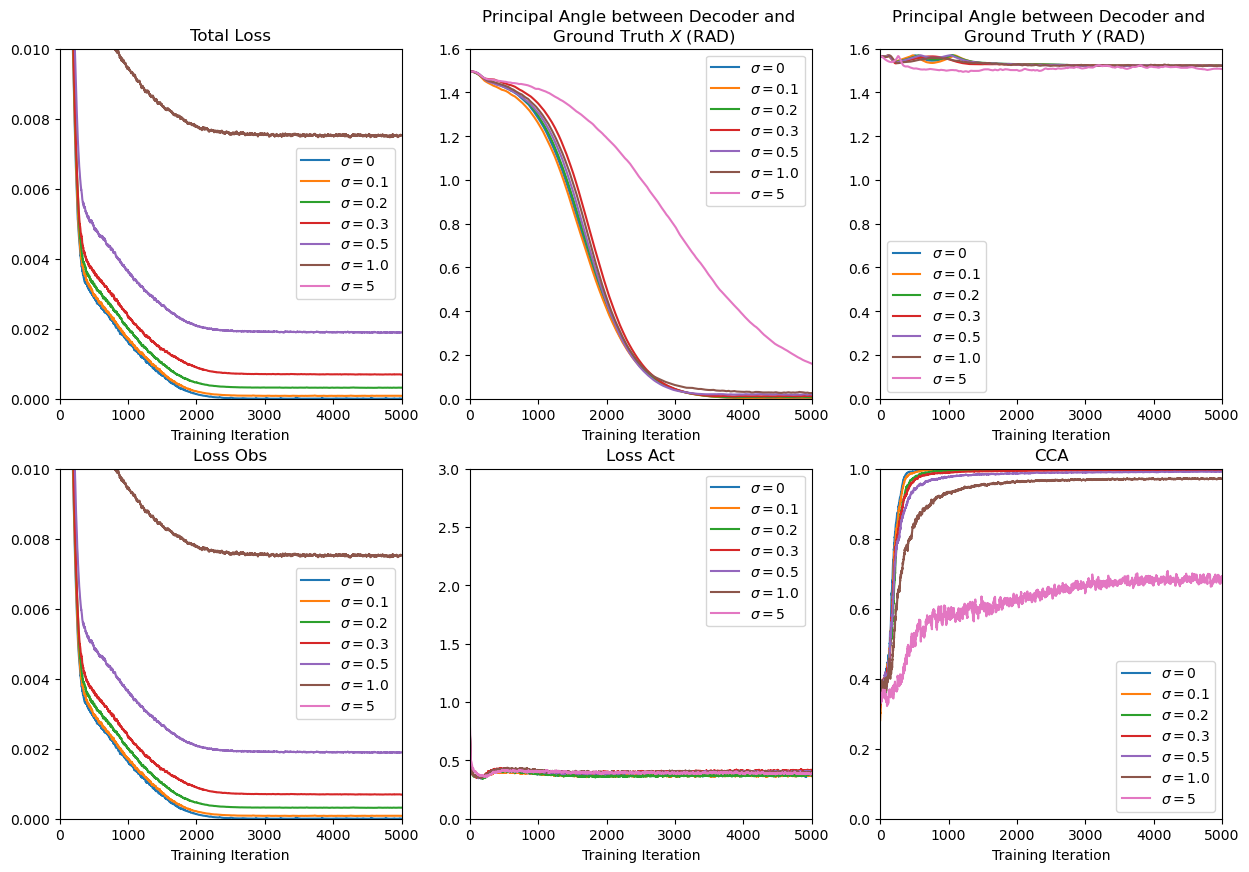

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Total Loss')

plt.subplot(2, 3, 2)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['angle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $X$ (RAD)')

plt.subplot(2, 3, 3)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['bngle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $Y$ (RAD)')

plt.subplot(2, 3, 4)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_obs'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Loss Obs')

plt.subplot(2, 3, 5)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_act'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 3])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Loss Act')

plt.subplot(2, 3, 6)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['cca'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('CCA')

# W/ 10% action label

Text(0.5, 1.0, 'CCA')

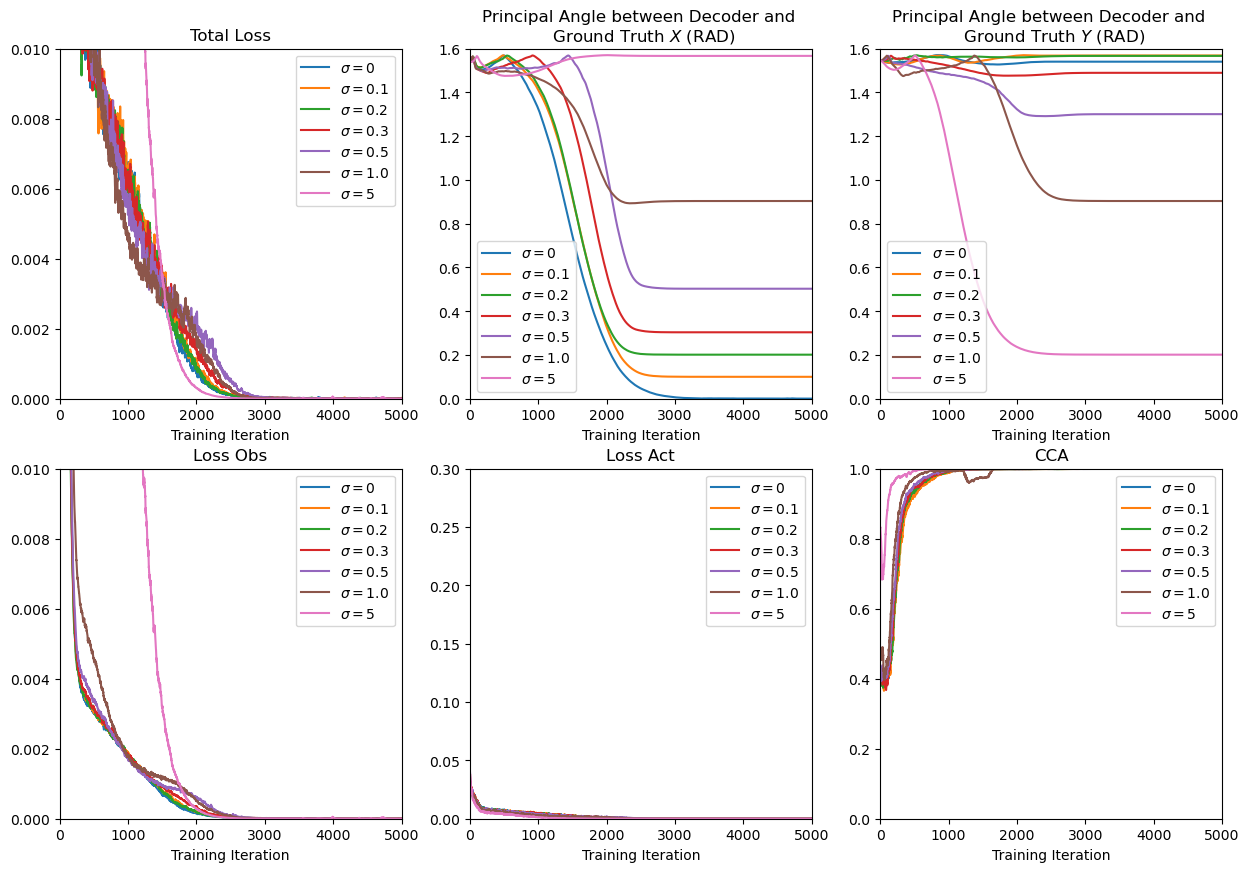

In [23]:
epsilon_list = [0, 0.1, 0.2, 0.3, 0.5, 1.0, 5]

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Total Loss')

plt.subplot(2, 3, 2)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['angle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $X$ (RAD)')

plt.subplot(2, 3, 3)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['bngle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $Y$ (RAD)')

plt.subplot(2, 3, 4)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_obs'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Loss Obs')

plt.subplot(2, 3, 5)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_act'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.3])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Loss Act')

plt.subplot(2, 3, 6)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['cca'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('CCA')

# Force predicting the 10% action label

Text(0.5, 1.0, 'CCA')

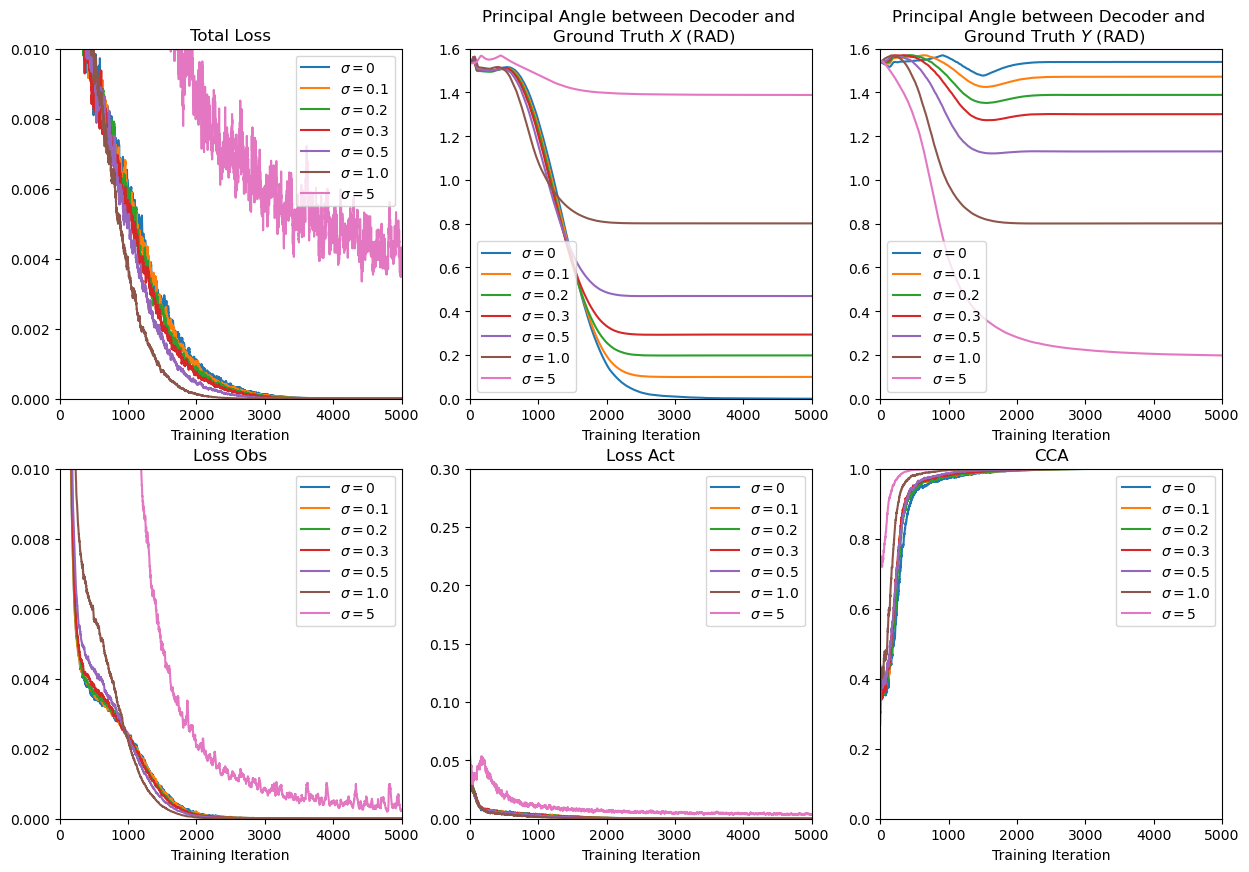

In [ ]:
epsilon_list = [0, 0.1, 0.2, 0.3, 0.5, 1.0, 5]

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Total Loss')

plt.subplot(2, 3, 2)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['angle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $X$ (RAD)')

plt.subplot(2, 3, 3)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['bngle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $Y$ (RAD)')

plt.subplot(2, 3, 4)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_obs'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Loss Obs')

plt.subplot(2, 3, 5)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_act'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.3])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Loss Act')

plt.subplot(2, 3, 6)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['cca'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('CCA')

# Force predicting the 90% action label

Text(0.5, 1.0, 'CCA')

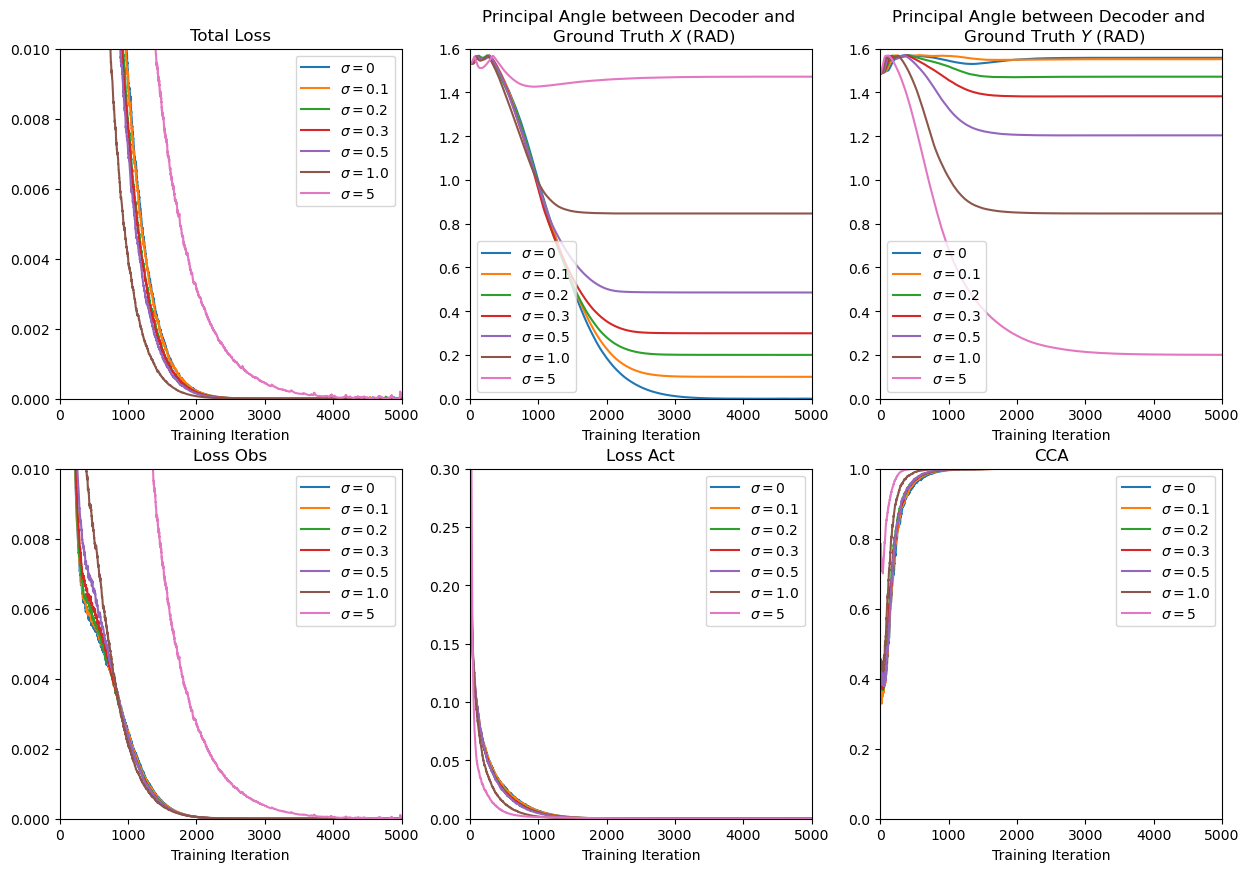

In [30]:
epsilon_list = [0, 0.1, 0.2, 0.3, 0.5, 1.0, 5]

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Total Loss')

plt.subplot(2, 3, 2)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['angle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $X$ (RAD)')

plt.subplot(2, 3, 3)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['bngle'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1.6])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Principal Angle between Decoder and \n Ground Truth $Y$ (RAD)')

plt.subplot(2, 3, 4)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_obs'], alpha=0.1).clip(lower=1e-6), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([0, 5000])
# plt.yscale('log')
plt.xlabel('Training Iteration')
plt.title('Loss Obs')

plt.subplot(2, 3, 5)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['loss_act'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 0.3])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('Loss Act')

plt.subplot(2, 3, 6)
for epsilon in epsilon_list:
    d = record.loc[record['noise'] == epsilon]
    plt.plot(d['batch'], tensorboard_smooth(d['cca'], alpha=0.1), label=f'$\sigma ={epsilon}$')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 5000])
plt.xlabel('Training Iteration')
plt.title('CCA')